# Results Analysis and Visualization

This notebook analyzes and visualizes the performance metrics of different models.

## Load Results

Load the metrics from CSV files and prepare data for visualization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter

load_dotenv()

True

In [4]:
results = pd.read_csv("reports/dencun_training_5.csv")

In [5]:

try:
    results['domain'] = results['model'].apply(lambda x: x.split('_')[1])
    results['embedding'] = results['model'].apply(lambda x: x.split('_')[2])
    results['model'] = results['model'].apply(lambda x: x.split('_')[0])
    results['latency'] = results['latency'] / 1_000_000
except Exception as e:
    print(e)

In [7]:
# Group by model, domain, and embedding type and calculate mean metrics
grouped_results = results.groupby(['model', 'domain']).agg({
    'accuracy': 'mean',
    'recall': 'mean',
    'precision': 'mean',
    'cost': 'mean',
    'latency': 'mean'
}).reset_index()

# Convert latency to log scale for better visualization
grouped_results['log_latency'] = np.log10(grouped_results['latency'])

# Save the grouped results to a CSV file
grouped_results.to_csv("reports/grouped_dencun_training.csv", index=False)

In [8]:
grouped_results

,model,domain,accuracy,recall,precision,cost,latency,log_latency
0,SVM,finance,98.186667,95.756667,98.833333,0.0,1442.370549,3.159077
1,SVM,healthcare,98.970000,97.143333,99.700000,0.0,1302.034049,3.114622
2,SVM,law,98.282000,95.588000,99.234000,0.0,1859.152680,3.269315
3,XGBoost,finance,97.520000,98.256667,94.723333,0.0,9.985182,0.999356
4,XGBoost,healthcare,97.806667,95.036667,98.180000,0.0,9.732601,0.988229
5,XGBoost,law,97.984000,95.530000,98.336000,0.0,10.035249,1.001528
6,fastText,finance,99.760000,99.570000,99.700000,0.0,0.069426,-1.158475
7,fastText,healthcare,99.770000,99.500000,99.800000,0.0,0.020365,-1.691114
8,fastText,law,99.680000,99.490000,99.560000,0.0,0.064359,-1.191389


## Visualization

Create various plots to compare model performance:
1. Bar chart comparing accuracy across domains
2. Scatter plot of precision vs latency
3. Bar chart of inference latency

In [9]:
domain_colors = {'law': 'cornflowerblue', 'healthcare': 'orange', 'finance': 'mediumseagreen'}

<Figure size 1400x800 with 0 Axes>

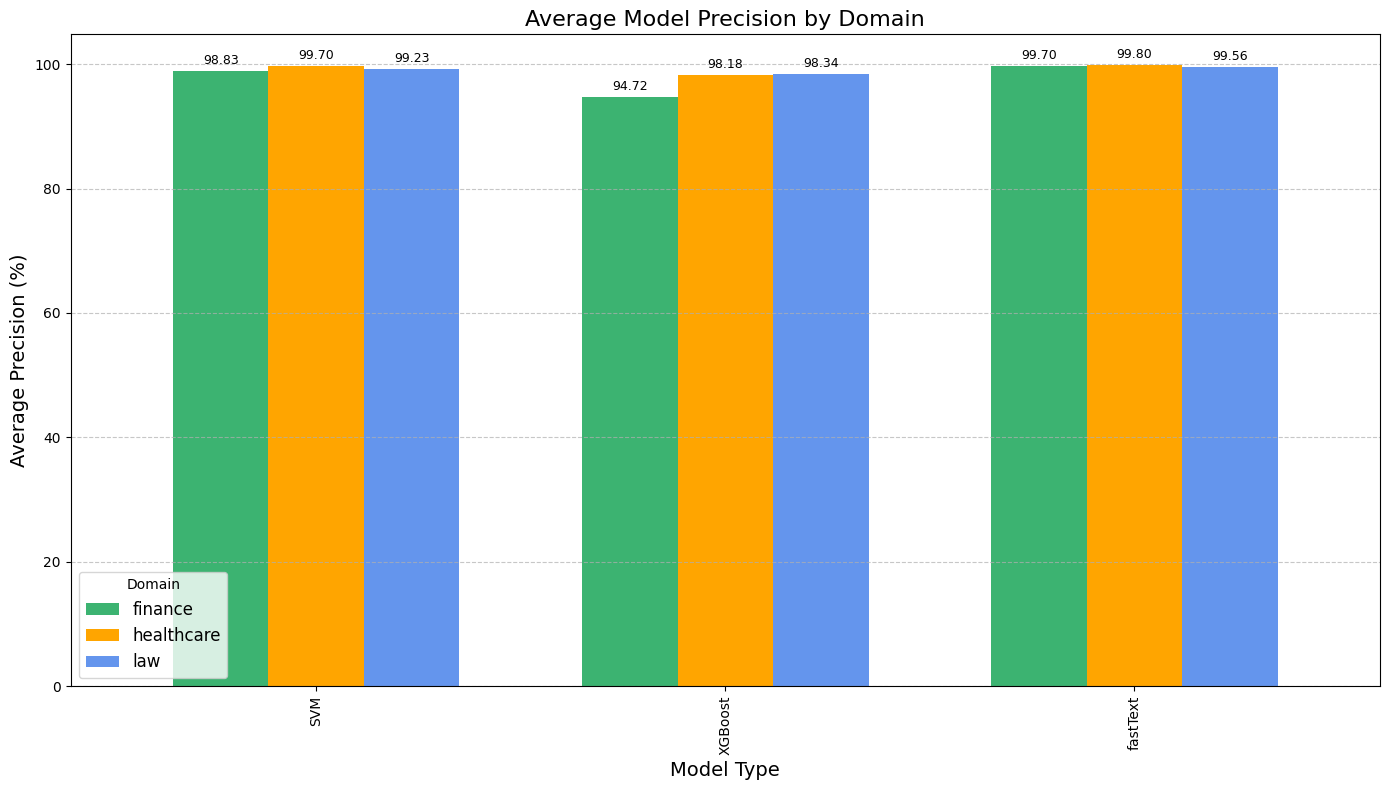

In [10]:
plt.figure(figsize=(14, 8))

accuracy_by_domain_model = grouped_results.pivot_table(
    values='precision',
    index='model',
    columns='domain',
    aggfunc='mean'
)

ax = accuracy_by_domain_model.plot(kind='bar', figsize=(14, 8), width=0.7, color=[domain_colors[col] for col in accuracy_by_domain_model.columns])

plt.title('Average Model Precision by Domain', fontsize=16)
plt.xlabel('Model Type', fontsize=14)
plt.ylabel('Average Precision (%)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Domain', fontsize=12)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=9)

plt.tight_layout()
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

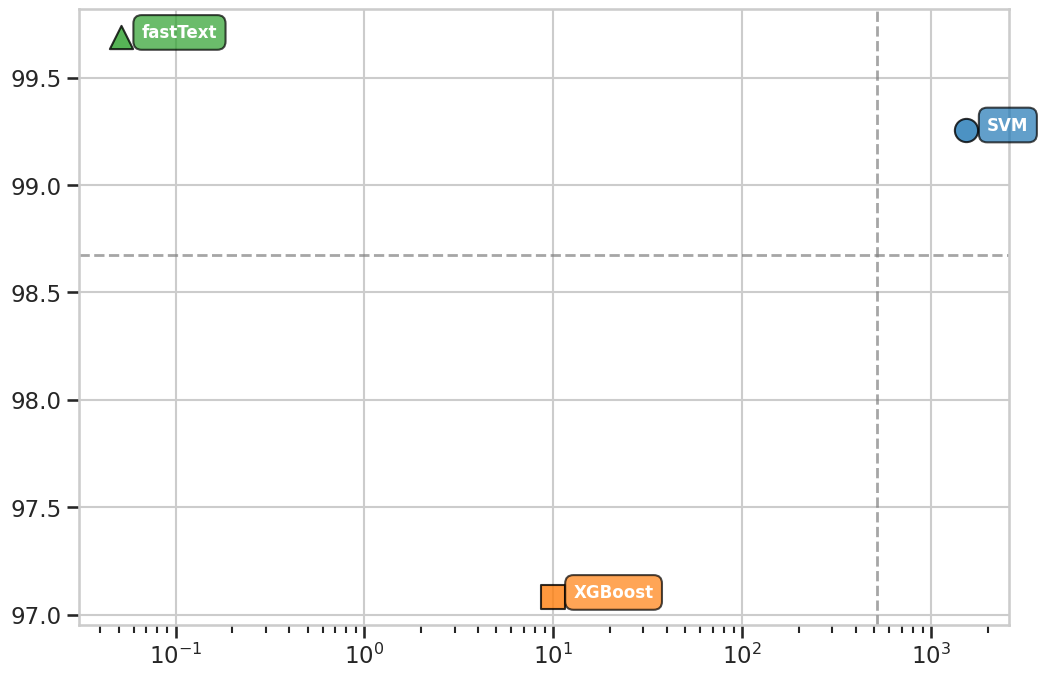

In [13]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

mean_grouped_results = grouped_results.groupby('model').mean(numeric_only=True).reset_index()
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)

# Define markers and colors for different model types
markers = {
    'SVM': 'o',
    'XGBoost': 's',
    'fastText': '^',
    'gpt4o-mini': 'D',
    'modernbert': 'p'
}
colors = {
    'SVM': '#1f77b4',         # blue
    'XGBoost': '#ff7f0e',       # orange
    'fastText': '#2ca02c',      # green
    'gpt4o-mini': '#d62728',    # red
    'modernbert': '#9467bd'     # purple
}

for idx, row in mean_grouped_results.iterrows():
    model = row['model']
    plt.scatter(row['latency'], row['precision'],
                marker=markers.get(model, '*'),
                color=colors.get(model, 'gray'),
                s=280,
                edgecolor='black',
                linewidth=1.5,
                alpha=0.8,
                zorder=10)

    label_text = f"{model}"
    bbox_props = {
        "boxstyle": 'round,pad=0.5',
        "fc": colors.get(model, 'gray'),
        "ec": "black",
        "alpha": 0.7,
        "lw": 1.5
    }
    plt.annotate(label_text,
                 xy=(row['latency'], row['precision']),
                 xytext=(15, 0),
                 textcoords='offset points',
                 fontsize=12,
                 fontweight='bold',
                 color='white',
                 bbox=bbox_props,
                 zorder=11)

avg_precision = mean_grouped_results['precision'].mean()
plt.axhline(y=avg_precision, color='gray', linestyle='--', alpha=0.7, linewidth=2,
            label=f'Avg Precision: {avg_precision:.2f}')

avg_latency = mean_grouped_results['latency'].mean()
plt.axvline(x=avg_latency, color='gray', linestyle='--', alpha=0.7, linewidth=2,
            label=f'Avg Latency: {avg_latency:.2f}')

plt.xscale('log')

legend_elements = [
    Patch(facecolor=colors[model], edgecolor='black',
          label=f"{model} (Precision: {mean_grouped_results[mean_grouped_results['model'] == model]['precision'].values[0]:.2f})")
    for model in colors
]
legend_elements.append(Patch(facecolor='gray', alpha=0.7, label=f'Avg Precision: {avg_precision:.2f}'))
legend_elements.append(Patch(facecolor='gray', alpha=0.7, label=f'Avg Latency: {avg_latency:.2f}'))
plt.legend(handles=legend_elements, loc='upper right',
           frameon=True, framealpha=0.9, edgecolor='black',
           fontsize=10, title='Model Performance', title_fontsize=12)

plt.title('Model Performance: Precision vs. Latency', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Latency (ms, log scale)', fontsize=16, labelpad=15)
plt.ylabel('Precision', fontsize=16, labelpad=15)

gradient = np.linspace(0, 1, 100).reshape(-1, 1)
plt.imshow(gradient, cmap=plt.cm.Blues, alpha=0.1, aspect='auto',
           extent=[ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]])

plt.grid(True, linestyle='--', alpha=0.4, linewidth=0.8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

q_left = np.exp((np.log(x_min) + np.log(avg_latency)) / 2)
q_right = np.exp((np.log(avg_latency) + np.log(x_max)) / 2)
q_bottom = (y_min + avg_precision) / 2
q_top = (avg_precision + y_max) / 2

# Annotate the quadrants
ax.text(q_left, q_top, 'High Precision\nLow Latency', ha='center', va='center',
        fontsize=12, fontweight='bold', color='black', alpha=0.8, zorder=12)
ax.text(q_left, q_bottom, 'Low Precision\nLow Latency', ha='center', va='center',
        fontsize=12, fontweight='bold', color='black', alpha=0.8, zorder=12)
ax.text(q_right, q_bottom, 'Low Precision\nHigh Latency', ha='center', va='center',
        fontsize=12, fontweight='bold', color='black', alpha=0.8, zorder=12)

# Add a subtle box around the plot
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('#333333')

plt.tight_layout()
plt.show()


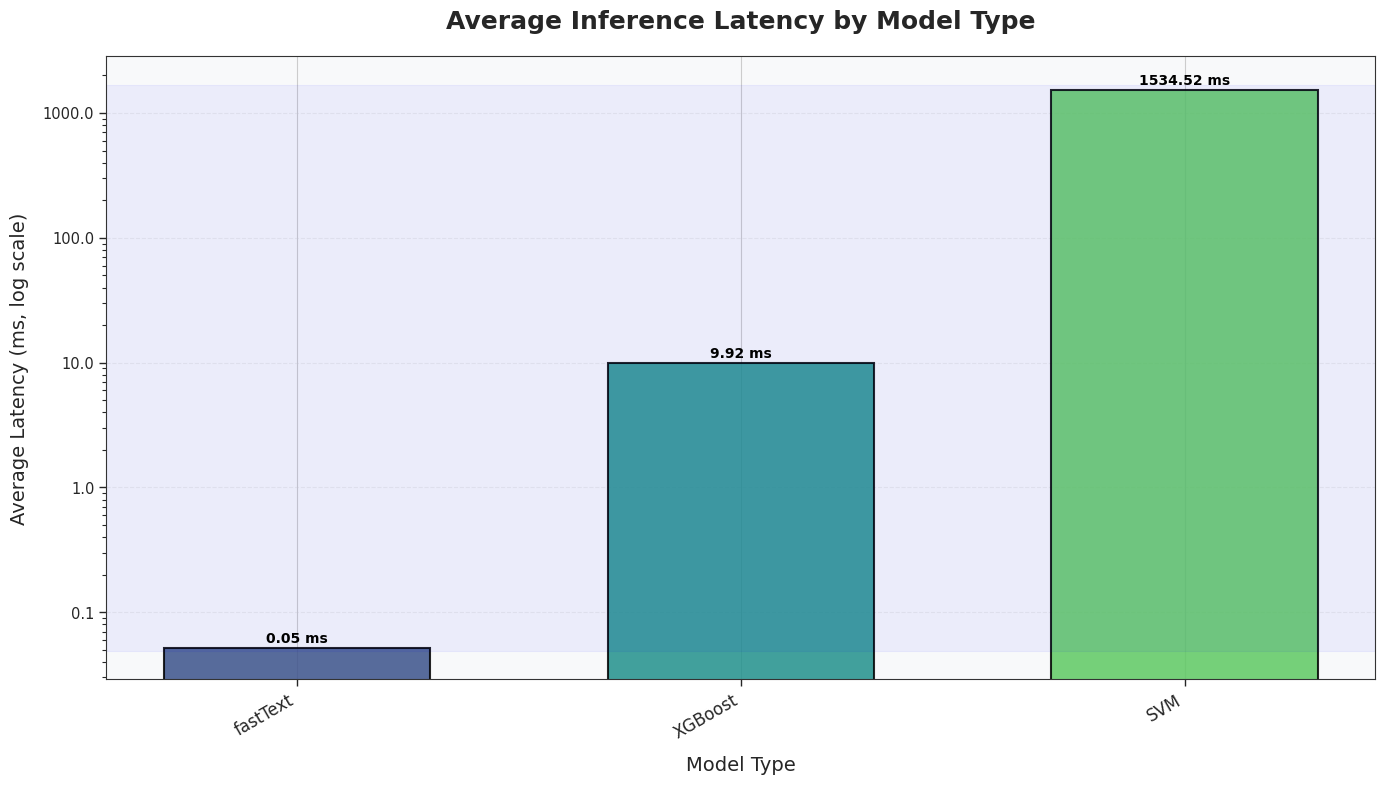

In [12]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
sns.set_context("paper", font_scale=1.2)

# Group data by model and calculate mean latency
latency_by_model = grouped_results.groupby('model')['latency'].mean().sort_values()

# Create the bar plot with improved styling
fig = plt.figure(figsize=(14, 8), dpi=100)
ax = fig.add_subplot(111) 

bars = plt.bar(latency_by_model.index, latency_by_model.values,
               color=sns.color_palette("viridis", len(latency_by_model)),
               edgecolor='black', linewidth=1.5, alpha=0.85,
               width=0.6)

# Add value labels on top of bars with better formatting
for bar in bars:
    height = bar.get_height()
    display_value = f'{height:.2f} ms'

    plt.text(bar.get_x() + bar.get_width()/2., height * 1.05,
             display_value, ha='center', va='bottom',
             fontsize=10, fontweight='bold', color='black')

plt.title('Average Inference Latency by Model Type', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Model Type', fontsize=14, labelpad=10)
plt.ylabel('Average Latency (ms, log scale)', fontsize=14, labelpad=10)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.xticks(rotation=30, ha='right', fontsize=12)

# Use logarithmic scale with better formatting
plt.yscale('log')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))

ax.set_facecolor('#f8f9fa')

# Add subtle spines
for spine in ax.spines.values():
    spine.set_linewidth(0.8)
    spine.set_color('#333333')

# Add light shading for visual appeal
plt.axhspan(latency_by_model.min()*0.95, latency_by_model.max()*1.1, alpha=0.05, color='blue')

plt.tight_layout()
plt.show()